## This script provides a guide of using CUDA-accelerated projector

#### Import python package 

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use("dark_background")
plt.rcParams['image.cmap'] = 'gray'

#### Import CTorch tools

"geometry" module is used to define scanning geometry (see [geometry.ipynb](./2_geometry.ipynb) for details)

In [2]:
import CTorch.utils.geometry as geometry
from CTorch.projector.projector_interface import Projector

#### Define [Geometry](./2_geometry.ipynb)

Here we take 2D geometry as an example, projector with 3D geoemtry can be created in the same way

In [3]:
nx, ny = 512,512 # image dimension
dx, dy = 0.8, 0.8 # image pixel size

nu = 1024 # detector length 
du = 1.0 # detecor pixel size
nView = 720 # number of views
viewAngles = np.arange(0,-2*np.pi,-2*np.pi/nView) # projection angle
detType = 'curve' #'curve'
SAD, SDD = [800.0], [1200.0] # source-axis-distance, source-detector-distance

xOfst, yOfst = [0.0], [0.0] # image center offset
uOfst = [0.0] # detecor center offset
xSrc = [100.0]

# define geometry object
geom = geometry.Geom2D(nx, ny, dx, dy, nu, nView, viewAngles, du, detType, SAD, SDD, 
                 xOfst = xOfst, yOfst = yOfst, uOfst = uOfst, xSrc = xSrc, fixed=True)  


#### Define projector

Two kinds of projectors are provided. The forward projector ($A$) computes the line integral of 2D/3D images according to the given geometry, and the back projector ($A^T$) backprojects the projection to the 2D/3D images.

Projector can be instantiated by: Projector(geom, projMode, projAlgo, projDirect)

- "geom" represents the geometry object, which can be 2D, circualr 3D, or noncircualr 3D geometry

- "projMode" can be "proj" or "recon", which is used for forward projection and backprojection in fbp, respectively. The only difference between these two modes is the [magnification-related projection weighting in fbp reconstruction](https://www.slaney.org/pct/pct-toc.html), which can be ignored with parallel beam approximation.

- "projAlgo" specifies the projector algorithm being used. Options: ["voxel"](https://books.google.com/books?hl=en&lr=&id=JX__lLLXFHkC&oi=fnd&pg=PR9&dq=jiang+hsieh&ots=RmO41mS0_u&sig=_boSppBiZxN6eoc6A393a6lLqBA#v=onepage&q=jiang%20hsieh&f=false), ["ray"](https://hrcak.srce.hr/clanak/221195), ["DD"](https://iopscience.iop.org/article/10.1088/0031-9155/49/11/024/meta), ["SF"](https://ieeexplore.ieee.org/abstract/document/5482021). "DD" and "SF" are the most accurate projectors while "voxel" and "ray" may provide higher computational efficiency.

- "projDirect" can be "forward" or "back", which means forward and back projection, respectively.

In [4]:
projAlgo = 'SF' 
backAlgo = 'SF'  
A = Projector(geom,'proj',projAlgo,'forward') # forward projector
AT = Projector(geom,'proj',backAlgo,'back') # back projector

#### Load example data

In [5]:
img = io.loadmat("img_example.mat")["img"]
img = torch.Tensor(img).reshape([1,1,ny,nx]).cuda()
img = img.repeat(2, 4, 1, 1)

#### Execute forward and back projection

In [6]:
sino = A(img)
imgb = AT(sino)

#### Display results

In [7]:
sino = sino.squeeze().cpu().detach().numpy()
imgb = imgb.squeeze().cpu().detach().numpy()
img = img.squeeze().cpu().detach().numpy()

Text(0.5, 1.0, 'Backprojection')

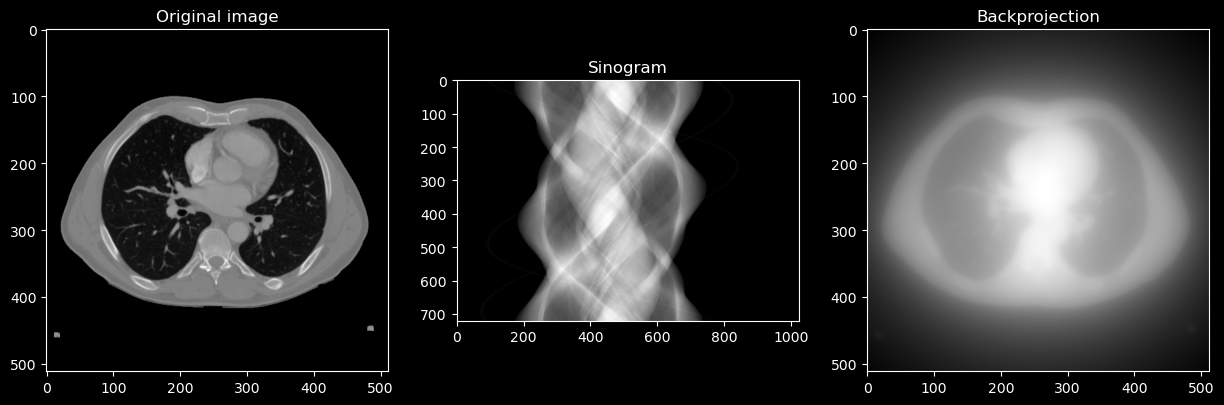

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img[0,0])
axes[0].set_title("Original image")

# Second subplot
axes[1].imshow(sino[0,0])
axes[1].set_title("Sinogram")

# Third subplot
axes[2].imshow(imgb[0,0])
axes[2].set_title("Backprojection")